In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import dlib
import cv2
import numpy as np
import math
#from renderFace import renderFace
import matplotlib.pyplot as plt

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [ ]:
DATA_PATH = "/content/gdrive/My Drive/E4P2/S3/images/"
MODEL_PATH = "/content/gdrive/My Drive/E4P2/S3/models/"

#Landmark model location
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"

In [ ]:
def writeLandmarksToFile(landmarks, landmarksFileName):
  with open(landmarksFileName, 'w') as f:
    for p in landmarks.parts():
      f.write(f"{int(p.x)} {int(p.y)}")
  f.close()


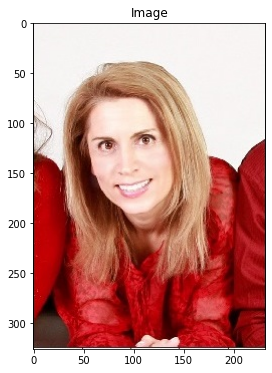

In [ ]:
#get face detector instance
faceDetector = dlib.get_frontal_face_detector()

# landmark detctor is implemented in shape predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# read image
imageFilename = DATA_PATH + "face2.jpg"
im = np.uint8(cv2.imread(imageFilename))

# landmarks will be stored in results/family_i.txt
landmarksBasename = "results/family"

plt.imshow(im[:,:,::-1])
plt.title("Image")
plt.show()

In [ ]:
# Returns 8 points on the boundary of a rectangle
def getEightBoundaryPoints(h, w):
  boundaryPts = []
  boundaryPts.append((0,0))
  boundaryPts.append((w/2, 0))
  boundaryPts.append((w-1,0))
  boundaryPts.append((w-1, h/2))
  boundaryPts.append((w-1, h-1))
  boundaryPts.append((w/2, h-1))
  boundaryPts.append((0, h-1))
  boundaryPts.append((0, h/2))
  return np.array(boundaryPts, dtype=np.float)


# Constrains points to be inside boundary
def constrainPoint(p, w, h):
  p = (min(max(p[0], 0), w - 1), min(max(p[1], 0), h - 1))
  return p

# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffine2D(np.array([inPts]), np.array([outPts]), False) #cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False)
  return tform

# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36], pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[0], pointsIn[2]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform[0], (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))
  
  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform[0])

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

# find the point closest to an array of points
# pointsArray is a Nx2 and point is 1x2 ndarray
def findIndex(pointsArray, point):
  dist = np.linalg.norm(pointsArray-point, axis=1)
  minIndex = np.argmin(dist)
  return minIndex


# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True


# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculateDelaunayTriangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunayTri = []

  for t in triangleList:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

  # Given a pair of triangles, find the affine transform.
  warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))

  # Offset points by left top corner of the respective rectangles
  t1Rect = []
  t2Rect = []
  t2RectInt = []

  for i in range(0, 3):
    t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

  # Apply warpImage to small rectangular patches
  img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

  size = (r2[2], r2[3])

  img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

  img2Rect = img2Rect * mask

  # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points

# Warps an image in a piecewise affine manner.
# The warp is defined by the movement of landmark points specified by pointsIn
# to a new location specified by pointsOut. The triangulation beween points is specified
# by their indices in delaunayTri.
def warpImage(imIn, pointsIn, pointsOut, delaunayTri):
  h, w, ch = imIn.shape
  # Output image
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Warp each input triangle to output triangle.
  # The triangulation is specified by delaunayTri
  for j in range(0, len(delaunayTri)):
    # Input and output points corresponding to jth triangle
    tin = []
    tout = []

    for k in range(0, 3):
      # Extract a vertex of input triangle
      pIn = pointsIn[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pIn = constrainPoint(pIn, w, h)

      # Extract a vertex of the output triangle
      pOut = pointsOut[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pOut = constrainPoint(pOut, w, h)

      # Push the input vertex into input triangle
      tin.append(pIn)
      # Push the output vertex into output triangle
      tout.append(pOut)

    # Warp pixels inside input triangle to output triangle.
    warpTriangle(imIn, imOut, tin, tout)
  return imOut

In [ ]:
points.shape

(5, 2)

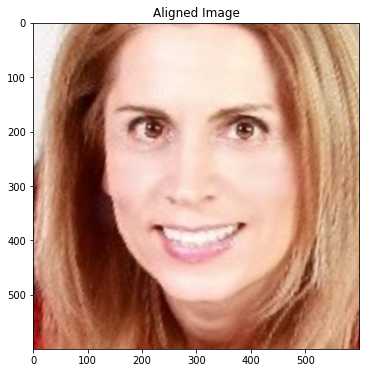

In [ ]:
#detect landmarks
points = getLandmarks(faceDetector, landmarkDetector, im) #fbc.getLandmarks(faceDetector, landmarkDetector, im)
points = np.array(points)

#convert image to floating point in the range 0 to 1
img = np.float32(im)/255.0

#dimensions of output image
h = 600
w = 600

#normalize image to output coordinates
imnorm, points = normalizeImagesAndLandmarks((h, w), img, points) #fbc.normalizeImagesAndLandmarks((h, w), im, points)

imnorm = np.uint8(imnorm*255)

#display the results
plt.imshow(imnorm[:,:,::-1])
plt.title("Aligned Image")
plt.show()

In [ ]:
def alignFace(predictor_path, imageFilename, h=600, w=600):
  #get face detector instance
  faceDetector = dlib.get_frontal_face_detector()

  # landmark detctor is implemented in shape predictor class
  landmarkDetector = dlib.shape_predictor(predictor_path)

  # read image
  #imageFilename = DATA_PATH + "face2.jpg"
  im = np.uint8(cv2.imread(imageFilename))

  #detect landmarks
  points = getLandmarks(faceDetector, landmarkDetector, im) #fbc.getLandmarks(faceDetector, landmarkDetector, im)
  points = np.array(points)

  #convert image to floating point in the range 0 to 1
  img = np.float32(im)/255.0

  #dimensions of output image
  # h = 600
  # w = 600

  #normalize image to output coordinates
  imnorm, points = normalizeImagesAndLandmarks((h, w), img, points) #fbc.normalizeImagesAndLandmarks((h, w), im, points)

  imnorm = np.uint8(imnorm*255)

  return imnorm

In [ ]:
imageFilename = DATA_PATH + "face2.jpg"
imnorm = alignFace(PREDICTOR_PATH, imageFilename, h=600, w=600)

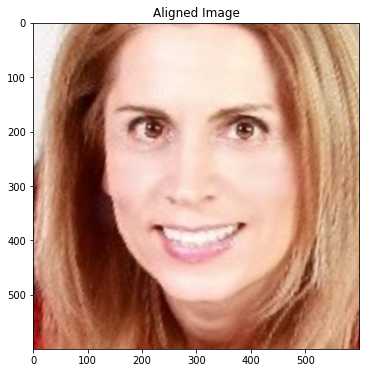

In [ ]:
#display the results
plt.imshow(imnorm[:,:,::-1])
plt.title("Aligned Image")
plt.show()